In [129]:
import cv2 as cv
from matplotlib import pyplot as plt
import json
import numpy as np
import os
from typing import List, Tuple, Dict

In [130]:
config = json.load(open("../config.json"))
print(config)
antrenare_folder = "../../antrenare/"
evaluare_folder = "../../evaluare/"
auxiliare_folder = "../../imagini_auxiliare/"

{'base_image_path': '../imagini_auxiliare/01.jpg', 'score_tracker': [-1, 1, 2, 3, 4, 5, 6, 0, 2, 5, 3, 4, 6, 2, 2, 0, 3, 5, 4, 1, 6, 2, 4, 5, 5, 0, 6, 3, 4, 2, 0, 1, 5, 1, 3, 4, 4, 4, 5, 0, 6, 3, 5, 4, 1, 3, 2, 0, 0, 1, 1, 2, 3, 6, 3, 5, 2, 1, 0, 6, 6, 5, 2, 1, 2, 5, 0, 3, 3, 5, 0, 6, 1, 4, 0, 6, 3, 5, 1, 4, 2, 6, 2, 3, 1, 6, 5, 6, 2, 0, 4, 0, 1, 6, 4, 4, 1, 6, 6, 3, 100], 'board': [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0

In [131]:
base_img = cv.imread("./fake_test/1_01.jpg")
first_img = cv.imread("./fake_test/1_02.jpg")

In [132]:
import sys

sys.path.insert(0, "../")
from util import (
    crop_board,
    print_image,
    color_filter,
    draw_grid,
    denoise,
    grid_mask,
    sharpen,
    edge_detect,
)

base_cropped = crop_board(base_img)
first_move_cropped = crop_board(first_img)

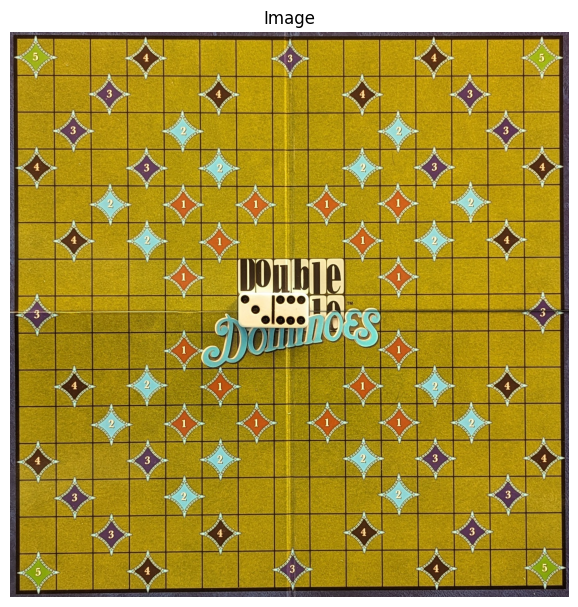

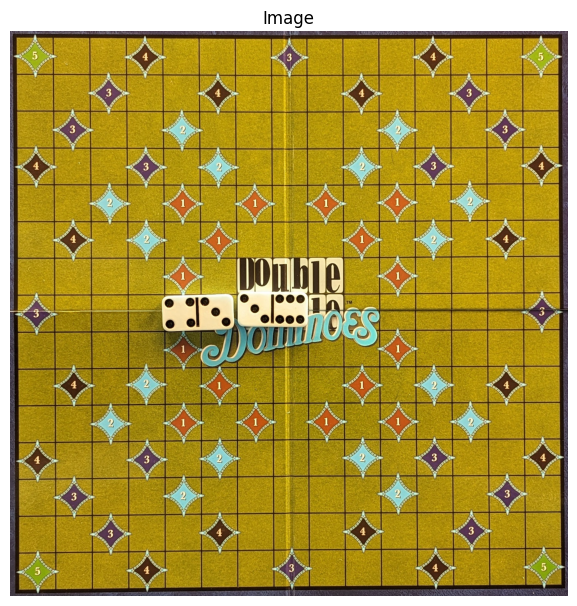

In [133]:
print_image(base_cropped, fft=False)
print_image(first_move_cropped, fft=False)

In [134]:
def pipeline(image):
    image = denoise(image)
    image = sharpen(image)
    image = edge_detect(image)
    mask, lines = grid_mask(image)
    return mask, lines


mask, grid = pipeline(base_cropped.copy())

In [135]:
def get_piece(prev_image, cur_image, grid):
    def pipeline(image):
        image = color_filter(image, np.uint8([[[200, 240, 250]]]), 60)
        image = cv.cvtColor(image, cv.COLOR_HSV2BGR)
        return image

    prev_image = pipeline(prev_image)
    cur_image = pipeline(cur_image)
    size = (
        max(prev_image.shape[1], cur_image.shape[1]),
        max(prev_image.shape[0], cur_image.shape[0]),
    )
    prev_image_diff = cv.resize(prev_image, size, interpolation=cv.INTER_AREA)
    cur_image_diff = cv.resize(cur_image, size, interpolation=cv.INTER_AREA)

    current_image = cur_image_diff.copy()

    image = 255 - cv.absdiff(prev_image_diff, cur_image_diff)

    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 160, 255, cv.THRESH_BINARY_INV)
    thresh = cv.morphologyEx(
        thresh, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1
    )
    thresh = cv.morphologyEx(
        thresh, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=3
    )
    thresh = cv.erode(thresh, np.ones((3, 3), np.uint8), iterations=2)
    # print_image(thresh, title="Threshold", fft=False)

    cnts, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    good_contours = []
    for contour in cnts:
        area = cv.contourArea(contour)
        if area > 15:
            x, y, w, h = cv.boundingRect(contour)
            aspect_ratio = max(w / h, h / w)
            if 1.9 < aspect_ratio < 2.1:
                # print(f"Area: {area}, Aspect Ratio: {aspect_ratio}")
                good_contours.append(contour)

    contour = max(cnts, key=cv.contourArea)

    contour_poly = cv.approxPolyDP(contour, 3, True)
    bounding_rect = cv.boundingRect(contour_poly)

    output = cv.drawContours(image, [contour_poly], -1, (255, 0, 0), 8)
    image = cv.rectangle(image, bounding_rect, (0, 255, 0), 6)

    draw_grid(image.copy(), mask, title="Grid Mask")
    # print_image(image, title="Contour", fft=False)

    x, y, w, h = bounding_rect
    locations = localize_piece(bounding_rect, grid)

    domino = current_image.copy()[y : y + h, x : x + w]
    domino = cv.cvtColor(domino, cv.COLOR_BGR2GRAY)
    # domino = cv.GaussianBlur(domino, (5, 5), 0)

    orientation = "horizontal"
    if h > w:
        orientation = "vertical"
        domino = cv.rotate(domino, cv.ROTATE_90_COUNTERCLOCKWISE)
        w, h = h, w

    left_rect_start = (0, 0)
    left_rect_end = (w // 2, h)

    right_rect_start = (w // 2, 0)
    right_rect_end = (w, h)

    left_square = domino[
        left_rect_start[1] : left_rect_end[1], left_rect_start[0] : left_rect_end[0]
    ]
    right_square = domino[
        right_rect_start[1] : right_rect_end[1], right_rect_start[0] : right_rect_end[0]
    ]

    def circles(image):
        circles = cv.HoughCircles(
            image,
            cv.HOUGH_GRADIENT_ALT,
            dp=1,
            minDist=30,
            param1=300,
            param2=0.2,
            minRadius=12,
            maxRadius=16,
        )

        if circles is not None:
            # print("circles:", circles)
            # print("circles len:", len(circles))
            # print("circles[0] len:", len(circles[0]))
            circles = np.uint16(np.around(circles))
            return circles
        return np.array([[]])

    left_circles = circles(left_square)
    right_circles = circles(right_square)

    domino = cv.cvtColor(domino, cv.COLOR_GRAY2RGB)

    # for circle in left_circles[0, :]:
    #     x, y, r = circle
    #     cv.circle(domino, (x, y), r, (0, 0, 255), 1)

    # for circle in right_circles[0, :]:
    #     x, y, r = circle
    #     cv.circle(domino, (x + w // 2, y), r, (0, 255, 0), 1)

    left_circles = len(left_circles[0, :])
    right_circles = len(right_circles[0, :])
    # print(left_circles, right_circles)

    cv.rectangle(domino, left_rect_start, left_rect_end, (0, 0, 255), 1)
    cv.rectangle(domino, right_rect_start, right_rect_end, (0, 255, 0), 1)
    print_image(domino, title="Domino", fft=False, gray=False)
    # print_image(
    #     domino,
    #     title="Domino",
    #     fft=False,
    #     gray=False,
    #     output_dir=f"./test/{int(time.time())}.jpg",
    # )
    # time.sleep(1)
    # print(locations)
    return (orientation, locations[0], left_circles, locations[1], right_circles)


def localize_piece(
    rect: Tuple[float, float, float, float], lines: Dict[str, List[Tuple[float, float]]]
) -> List[Tuple[int, int]]:
    x, y, w, h = rect

    vertical_lines = sorted([line[0] * np.cos(line[1]) for line in lines["vertical"]])
    horizontal_lines = sorted(
        [line[0] * np.sin(line[1]) for line in lines["horizontal"]]
    )

    # Function to find grid squares that the rectangle potentially overlaps
    def find_overlapping_squares():
        overlapping_squares = []
        for i in range(len(horizontal_lines) - 1):
            for j in range(len(vertical_lines) - 1):
                if (
                    horizontal_lines[i] < y + h
                    and horizontal_lines[i + 1] > y
                    and vertical_lines[j] < x + w
                    and vertical_lines[j + 1] > x
                ):
                    overlapping_squares.append((i, j))
        return overlapping_squares

    overlapping_squares = find_overlapping_squares()

    # Calculate intersection areas for each overlapping grid square
    intersection_areas = {}
    for i, j in overlapping_squares:
        top = max(y, horizontal_lines[i])
        bottom = min(y + h, horizontal_lines[i + 1])
        left = max(x, vertical_lines[j])
        right = min(x + w, vertical_lines[j + 1])

        area = max(0, right - left) * max(0, bottom - top)
        if area > 0:
            intersection_areas[(i, j)] = area

    # Find the two squares with the largest intersection areas
    top_two_squares = sorted(
        intersection_areas, key=intersection_areas.get, reverse=True
    )[:2]
    return top_two_squares

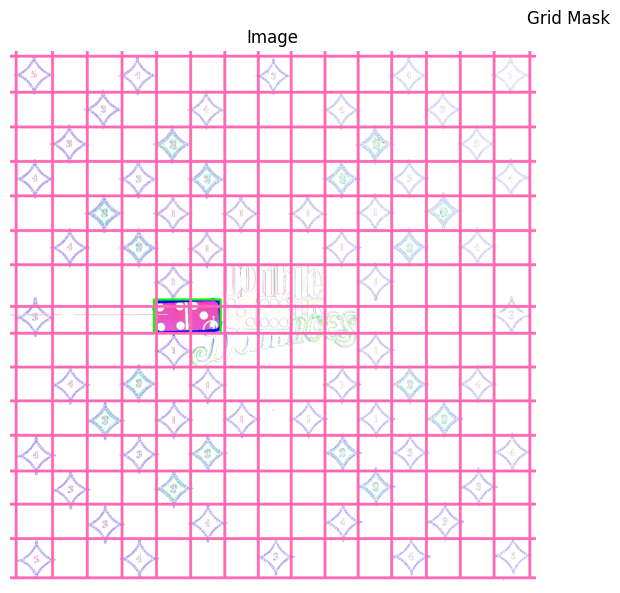

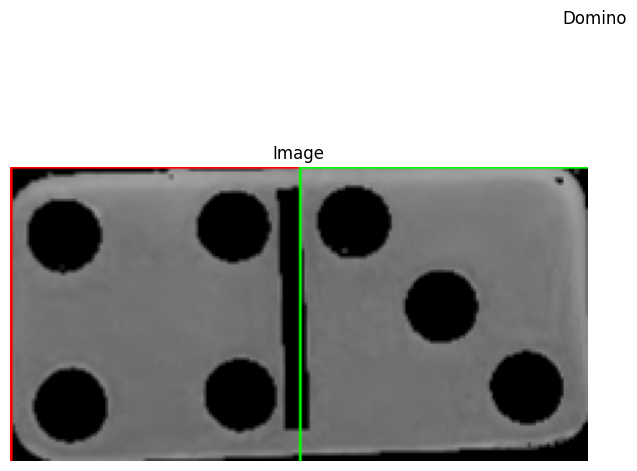

('horizontal', (7, 4), 4, (7, 5), 3)

In [136]:
get_piece(base_cropped, first_move_cropped, grid)